# Anomaly Detection in Forest Cover Data

## **Part 1: Getting started**

We are going to work with a forest cover dataset: http://odds.cs.stonybrook.edu/forestcovercovertype-dataset/. This dataset contains 10 quantitative features that contain cartographic information.

Load the dataset in CSV file using Pandas. The dataset is called `forest_data_all.csv`. Print out the first few columns of the dataset.

* How many rows are there? **286048** **[0.1]**
* Which column contains the targets? **Anomaly** **[0.1]**
* What is the meaning of target values? '1' is an outlier, '0' is an 'inlier' **[0.2]**

In [1]:
pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import wget

wget.download('https://github.com/APS1070-W23/datasets/raw/main/forest_data_all.tar.gz','forest_data_all.tar.gz')

'forest_data_all.tar (4).gz'

In [3]:
!tar -zxvf forest_data_all.tar.gz

forest_data_all.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
df = pd.read_csv('forest_data_all.csv')

In [5]:
print("Dataframe Shape: ", df.shape)
df.head()

Dataframe Shape:  (286048, 11)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Anomaly
0,2804,139,9,268,65,3180,234,238,135,6121,0
1,2785,155,18,242,118,3090,238,238,122,6211,0
2,2579,132,6,300,-15,67,230,237,140,6031,0
3,2886,151,11,371,26,5253,234,240,136,4051,0
4,2742,134,22,150,69,3215,248,224,92,6091,0


It's important to know how many examples we have for each class when we work with a new dataset.

* What is the percentage of entries in the dataset for each class? **[0.1]** 
  - 99.4% of the dataset are inliers ('0') whereas 0.96% are outliers ('1') 
* Is this data considered balanced or unbalanced? Why is this the case?   **[0.1]**
  - This is an unbalanced data as the target labels are highly skewed towards one value. 
* Why is balance/imbalance important? How might this class ditribution affect a KNN classifier for example, which we explored in Project 1? **[0.5]**
  - The balance is important because if we train our classifier based on a highly imbalanced dataset, it is very likely that the model will output a high accuracy but will fail to detect anomalies that constitute a very small percentage of the dataset. For the forest cover dataset, with **all the outliers classified as an inlier**, the model trained with a KNN classifier will report a very high accuracy of 99% which can be misleading, particularly when identifying anomalies in the dataset. 
* What metrics should we use to evaluate a model in such cases **[0.2]**
  - Metrics like precision, recall, f1-score should be used to evaluate an anomaly detection model. 


In [6]:
anomaly_percent = 100 * df.groupby('Anomaly').Anomaly.count() / df['Anomaly'].count()
print (anomaly_percent)

Anomaly
0    99.039672
1     0.960328
Name: Anomaly, dtype: float64


Next, split the dataset into a training (65%), validation (20%) and testing set (15%). Set the random state to 40. **[0.2]**

Make sure to separate out the column corresponding to the targets.

In [7]:
### Split the data  ###
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:10], 
                                                    df.iloc[:,10],
                                                    test_size=0.15,
                                                    random_state=40,
                                                    shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train,
                                                  test_size=0.2353,
                                                  random_state=40,
                                                  shuffle=True)

Now, let's take a look at the difference in distribution for some variables between anomalous and non-anomalous forests:

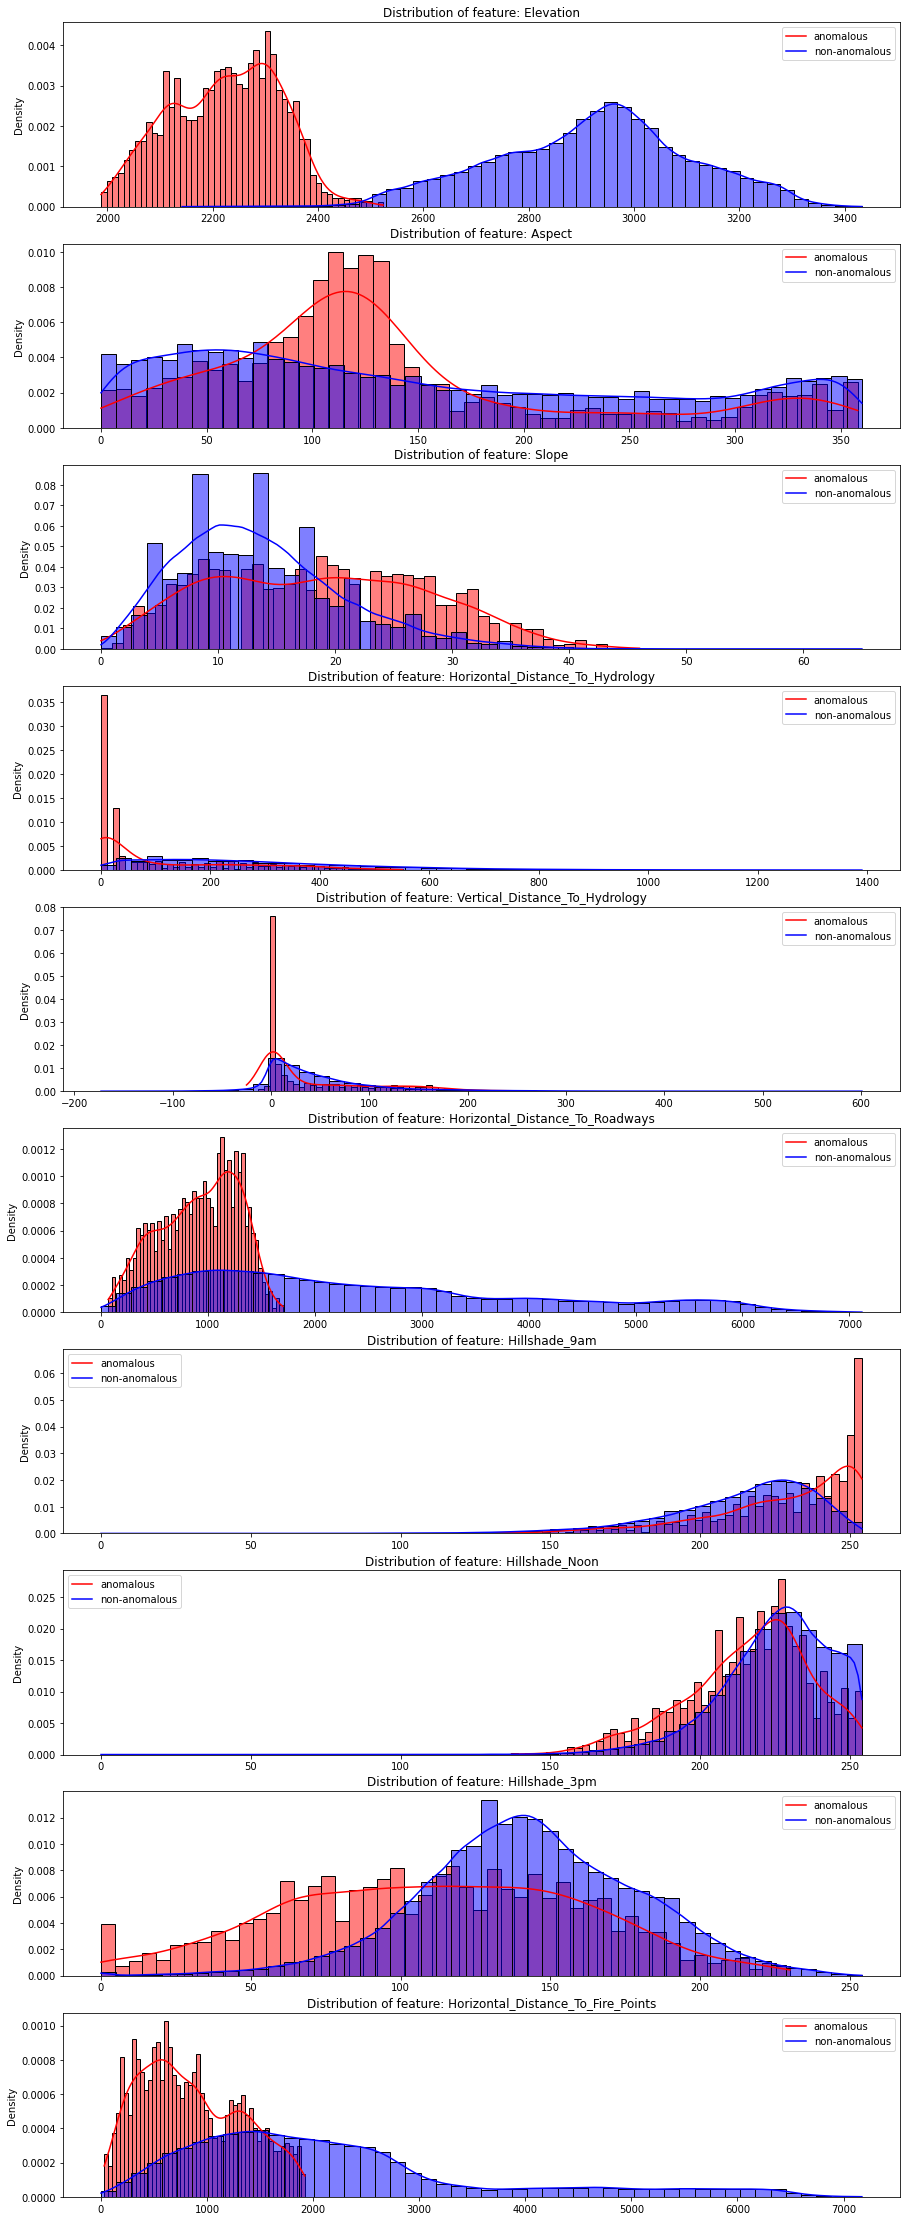

In [8]:
import matplotlib.gridspec as gridspec
features=[f for f in df.columns if not 'id' in f and not 'Anomaly' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(X_train[feat][y_train==1], stat="density", kde=True, color="red", bins=50)
    sns.histplot(X_train[feat][y_train==0], stat="density", kde=True, color="blue", bins=50)
    ax.legend(['anomalous', 'non-anomalous'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Explain how these graphs could provide meaningful information about anomaly detection using a gaussian model. **[0.5]**

Each histogram plot tries to fit a gaussian distribution based on a dataset-feature for both anomalous and non-anomalous data. These graphs can help in identifying the features that differentiate the anamalous data from the non-anomalous ones. 

For instance, the elevation feature clearly seggregates the anomoulus data where elevations ranging from 2000-2400 m have a very high likelihood for the data to be anomalous.

Another interesting observation is the the Hillshade_Noon feature shows very similar distribution for both labels. In other words, Hillshade_Noon is a weak feature to classify a data as anomalous or non-anomalaous. 

## **Part 2: One Gaussian model with Single feature:**
We'll start by making a prediction using **a single feature of our dataset at a time**. 

Please note that we **only use `V` features** in our model.

**a. Fitting regardless of class:**
  1. Fit a single Gaussian distribution on a single feature of **the full training dataset** (both classes) using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. 
  2. Compute AUC (Area under the ROC Curve) based on ``sklearn.mixture.GaussianMixture.score_samples`` on both the full training set and validation set (including both classes).  
  3. Repeat the above steps for each of the features and present your findings in a table. **[0.3]**
  4. Find the best 3 features to distinguish anomalous forests from non-anomalous forests based on the AUC of the validation set. **[0.2]**
  5. Make a prediction based on a model's scores: If the `score_samples` is lower than a threshold, we consider that forest as an anomaly. Find an optimal threshold that maximizes the F1 Score of the validation set for each of those 3 features separately. (Do not check every possible value for threshold, come up with a faster way!) Compute F1 score using `sklearn.metrics.f1_score`. **[0.5]**
  7. Report Precision, Recall and F1 score on both training and validation set in a table using the threshold you found in previous step. 
  6. Report the complexity of your method (Big O notation) for determining the optimal threshold.**[0.3]**

**b. Fitting based on class:**
 1. Pick 3 features that had the best AUC in Part 2a. 
 2. repeat part 2a to compute AUC, F1 score, Precision and Recall when you fit a Gaussian **only on non-anomalous forests in the training set** in step 1 (instead of all the forests).
 3. Compare your results from parts 2a and 2b in a table (for both training and validation set). **[0.2]**
 4. Are these results different or similar? Why?**[0.3]**
 5. How would class imbalance affect any classifier in general (apart from just a KNN)? **[0.2]**


###**PART 2a** - Fitting Regardless of Class

In [9]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score

auc_table_oneFeature = pd.DataFrame(columns=('Feature', 'AUC_Train', "AUC_Validation"))
gm = GaussianMixture(n_components=1, random_state=0)
for features_ in range(len(X_train.columns)):
  train_data = np.array(X_train.iloc[:,features_]).reshape(-1,1)
  val_data = np.array(X_val.iloc[:,features_]).reshape(-1,1)

  '''
  Fit a single Gaussian distribution on a single feature of the full training 
  dataset (both classes) using sklearn.mixture.GaussianMixture 
  when n_components=1.
  '''

  gm.fit(train_data)

  '''
  Compute AUC (Area under the ROC Curve) based on 
  sklearn.mixture.GaussianMixture.score_samples on both the full training set 
  and validation set (including both classes).
  '''
  logProb_gm_train = gm.score_samples(train_data)
  auc_train = roc_auc_score(y_train, -1 * logProb_gm_train)
  logProb_gm_val = gm.score_samples(val_data)
  auc_val = roc_auc_score(y_val, -1 * logProb_gm_val)

  
  auc_table_oneFeature.loc[features_] = [df.columns[features_], auc_train, auc_val]

auc_table_oneFeature


,Feature,AUC_Train,AUC_Validation
0,Elevation,0.999356,0.999233
1,Aspect,0.378535,0.359695
2,Slope,0.645240,0.648386
3,Horizontal_Distance_To_Hydrology,0.655721,0.645417
4,Vertical_Distance_To_Hydrology,0.650022,0.638434
5,Horizontal_Distance_To_Roadways,0.611056,0.617103
6,Hillshade_9am,0.642709,0.627763
7,Hillshade_Noon,0.535048,0.547454
8,Hillshade_3pm,0.664751,0.650069
9,Horizontal_Distance_To_Fire_Points,0.673600,0.661756


In [10]:
print("Best 3 features to classify anomalous forests: ")
best_auc_df = auc_table_oneFeature.nlargest(3, ['AUC_Validation'])
best_auc_df
# auc_table[{'AUC_Train','AUC_Validation'}][data_pandas['AUC_Train']<0.645]

Best 3 features to classify anomalous forests: 


,Feature,AUC_Train,AUC_Validation
0,Elevation,0.999356,0.999233
9,Horizontal_Distance_To_Fire_Points,0.673600,0.661756
8,Hillshade_3pm,0.664751,0.650069


In [61]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# OGSF --> One Gaussian Single Feature
OGSF_df = pd.DataFrame(columns=('Feature', 'Threshold', "F1_score_Val"))

threshold_values = np.zeros(best_auc_df.shape[0])
f1_scores = np.zeros(best_auc_df.shape[0])


for i in range(best_auc_df.shape[0]):
  train_data = np.array(X_train[best_auc_df.iloc[i]['Feature']]).reshape(-1,1)
  val_data = np.array(X_val[best_auc_df.iloc[i]['Feature']]).reshape(-1,1)

  gm.fit(train_data)

  logProb_gm_val = gm.score_samples(val_data)

  '''
  Make a prediction based on a model's scores: If the score_samples is lower 
  than a threshold, we consider that forest as an anomaly. 
  Find an optimal threshold that maximizes the F1 Score of the validation set 
  for each of those 3 features separately.
  '''

  # Ternary Search to find the Optimal threshold value 
  threshold = None
  f1_score_max = None
  interval_low = min(logProb_gm_val)
  interval_high = max(logProb_gm_val)

  while abs(interval_low - interval_high) > 0.1:
    mid1 = interval_low + (interval_high - interval_low)/3
    mid2 = interval_high - (interval_high - interval_low)/3
    y_pred_mid1 = np.zeros(len(y_val))
    y_pred_mid2 = np.zeros(len(y_val))

    y_pred_mid1[logProb_gm_val < mid1] = 1
    y_pred_mid2[logProb_gm_val < mid2] = 1
    f1_score_mid1 = f1_score(y_val, y_pred_mid1, average='binary') 
    f1_score_mid2 = f1_score(y_val, y_pred_mid2, average='binary') 

    if f1_score_mid1 <= f1_score_mid2:
      interval_low = mid1  
    else:
      interval_high = mid2
    
    threshold = mid2
    f1_score_max = f1_score_mid2

  OGSF_df.loc[i] = [best_auc_df.iloc[i]['Feature'],
                           round(threshold,1),
                           round(f1_score_max,4)]

  threshold_values[i] = threshold
  f1_scores[i] = f1_score_max

print("Optimized Threshold for Best 3 features: ")
OGSF_df

Optimized Threshold for Best 3 features: 


,Feature,Threshold,F1_score_Val
0,Elevation,-9.9,0.8787
1,Horizontal_Distance_To_Fire_Points,-8.6,0.0343
2,Hillshade_3pm,-7.7,0.0952


In [58]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_scores_train = []
precision_scores_val = []
recall_scores_train = []
recall_scores_val = []
f1_scores_train = []

'''
Report Precision, Recall and F1 score on both training and validation set in 
a table using the threshold you found in previous step.
'''

for i in range(OGSF_df.shape[0]):
  train_data = np.array(X_train[OGSF_df.iloc[i]['Feature']]).reshape(-1,1)
  val_data = np.array(X_val[OGSF_df.iloc[i]['Feature']]).reshape(-1,1)
  y_predicted_train = np.zeros(len(y_train))
  y_predicted_val = np.zeros(len(y_val))

  gm.fit(train_data)
  logProb_gm_train = gm.score_samples(train_data)
  logProb_gm_val = gm.score_samples(val_data)

  threshold = OGSF_df.iloc[i]['Threshold'] #Threshold from the previous step
  
  y_predicted_train[logProb_gm_train < threshold] = 1
  y_predicted_val[logProb_gm_val < threshold] = 1

  precision_scores_train.append(precision_score(y_train, y_predicted_train))
  precision_scores_val.append(precision_score(y_val, y_predicted_val))

  recall_scores_train.append(recall_score(y_train, y_predicted_train))
  recall_scores_val.append(recall_score(y_val, y_predicted_val))

  f1_scores_train.append(f1_score(y_train, y_predicted_train, average='binary'))

OGSF_df['F1_score_Train'] = precision_scores_train
OGSF_df['Precision_Train'] = precision_scores_train
OGSF_df['Precision_Val'] = precision_scores_val
OGSF_df['Recall_Train'] = recall_scores_train
OGSF_df['Recall_Val'] = recall_scores_val

print("Performance Metric for 3 best features using ROC-AUC | Threshold optimized on F1 Score")

OGSF_df

Performance Metric for 3 best features using ROC-AUC | Threshold optimized on F1 Score


,Feature,Threshold,F1_score_Val,F1_score_Train,Precision_Train,Precision_Val,Recall_Train,Recall_Val
0,Elevation,-9.9,0.8787,0.826341,0.826341,0.815100,0.952220,0.956600
1,Horizontal_Distance_To_Fire_Points,-8.6,0.0343,0.017866,0.017866,0.017865,0.543002,0.535262
2,Hillshade_3pm,-7.7,0.0952,0.074564,0.074564,0.077374,0.120292,0.119349


**Time complexity** : In the threshold optimization algorithm, we are reducing the search space by a factor of 3 in each iteration. Therefore, the Time complexity to find the optimal threshold value can be given by :  $O(\log_3 n)$

###**PART 2b** - Fitting based on Class

In [14]:

# Creating an empty Dataframe to store results
OGSF_oneclass_df = pd.DataFrame(columns=('Feature', 'Threshold', "F1_score_Val"))

threshold_values = np.zeros(best_auc_df.shape[0])
f1_scores = np.zeros(best_auc_df.shape[0])

X_train_oneclass = X_train[y_train == 0]

'''
Pick 3 features that had the best AUC in Part 2a.
'''
for i in range(best_auc_df.shape[0]):
  fit_data = np.array(X_train_oneclass[best_auc_df.iloc[i]['Feature']]).reshape(-1,1)
  val_data = np.array(X_val[best_auc_df.iloc[i]['Feature']]).reshape(-1,1)

  '''
  fit a Gaussian only on non-anomalous forests in the training set in step 1 
  (instead of all the forests)
  '''
  gm.fit(fit_data)
  
  logProb_gm_val = gm.score_samples(val_data)
  threshold = None
  f1_score_max = None
  interval_low = min(logProb_gm_val)
  interval_high = max(logProb_gm_val)

  while abs(interval_low - interval_high) > 0.1:
    mid1 = interval_low + (interval_high - interval_low)/3
    mid2 = interval_high - (interval_high - interval_low)/3
    y_pred_mid1 = np.zeros(len(y_val))
    y_pred_mid2 = np.zeros(len(y_val))

    y_pred_mid1[logProb_gm_val < mid1] = 1
    y_pred_mid2[logProb_gm_val < mid2] = 1
    f1_score_mid1 = f1_score(y_val, y_pred_mid1, average='binary') 
    f1_score_mid2 = f1_score(y_val, y_pred_mid2, average='binary') 

    if f1_score_mid1 <= f1_score_mid2:
      interval_low = mid1  
    else:
      interval_high = mid2
    
    threshold = mid2
    f1_score_max = f1_score_mid2

  OGSF_oneclass_df.loc[i] = [best_auc_df.iloc[i]['Feature'],
                           round(threshold,1),
                           round(f1_score_max,4)]

  threshold_values[i] = threshold
  f1_scores[i] = f1_score_max

print("Optimized Threshold for Best 3 features  (based on GaussianMixture.score_samples, Model Fit only on Non-Anomalous Data) ")

precision_scores_train = []
precision_scores_val = []
recall_scores_train = []
recall_scores_val = []
f1_scores_train = []

for i in range(OGSF_oneclass_df.shape[0]):
  fit_data = np.array(X_train_oneclass[OGSF_oneclass_df.iloc[i]['Feature']]).reshape(-1,1)
  train_data = np.array(X_train[OGSF_oneclass_df.iloc[i]['Feature']]).reshape(-1,1)
  val_data = np.array(X_val[OGSF_oneclass_df.iloc[i]['Feature']]).reshape(-1,1)
  y_predicted_train = np.zeros(len(y_train))
  y_predicted_val = np.zeros(len(y_val))

  gm.fit(fit_data)
  logProb_gm_train = gm.score_samples(train_data)
  logProb_gm_val = gm.score_samples(val_data)

  threshold = OGSF_oneclass_df.iloc[i]['Threshold']
  
  y_predicted_train[logProb_gm_train < threshold] = 1
  y_predicted_val[logProb_gm_val < threshold] = 1

  precision_scores_train.append(precision_score(y_train, y_predicted_train))
  precision_scores_val.append(precision_score(y_val, y_predicted_val))

  recall_scores_train.append(recall_score(y_train, y_predicted_train))
  recall_scores_val.append(recall_score(y_val, y_predicted_val))

  f1_scores_train.append(f1_score(y_train, y_predicted_train, average='binary'))

OGSF_oneclass_df['F1_score_Train'] = precision_scores_train
OGSF_oneclass_df['Precision_Train'] = precision_scores_train
OGSF_oneclass_df['Precision_Val'] = precision_scores_val
OGSF_oneclass_df['Recall_Train'] = recall_scores_train
OGSF_oneclass_df['Recall_Val'] = recall_scores_val

OGSF_oneclass_df


Optimized Threshold for Best 3 features  (based on GaussianMixture.score_samples, Model Fit only on Non-Anomalous Data) 


,Feature,Threshold,F1_score_Val,F1_score_Train,Precision_Train,Precision_Val,Recall_Train,Recall_Val
0,Elevation,-10.1,0.8792,0.803803,0.803803,0.797059,0.974143,0.980108
1,Horizontal_Distance_To_Fire_Points,-8.6,0.0344,0.018008,0.018008,0.017946,0.551996,0.542495
2,Hillshade_3pm,-7.8,0.0952,0.078281,0.078281,0.081737,0.114671,0.115732


In [15]:
'''
Compare your results from parts 2a and 2b in a table (for both training and validation set).
'''

OGSF_oneclass_df.compare(OGSF_df, keep_equal=True).rename(columns={'self': 'OneClass', 'other': 'BothClass'}, level=-1)

Threshold           F1_score_Val           F1_score_Train            \
   OneClass BothClass     OneClass BothClass       OneClass BothClass   
0     -10.1      -9.9       0.8792    0.8787       0.803803  0.826341   
1      -8.6      -8.6       0.0344    0.0343       0.018008  0.017866   
2      -7.8      -7.7       0.0952    0.0952       0.078281  0.074564   

  Precision_Train           Precision_Val           Recall_Train            \
         OneClass BothClass      OneClass BothClass     OneClass BothClass   
0        0.803803  0.826341      0.797059  0.815100     0.974143  0.952220   
1        0.018008  0.017866      0.017946  0.017865     0.551996  0.543002   
2        0.078281  0.074564      0.081737  0.077374     0.114671  0.120292   

  Recall_Val            
    OneClass BothClass  
0   0.980108  0.956600  
1   0.542495  0.535262  
2   0.115732  0.119349

From the comparison table, we do not observe significant difference between the two models since anomalous data only constitutes about 1% of the entire training dataset.

**Effect of Class Imbalance:**
When the class distribution is not balanced, or the dataset is highly skewed, a classifier might seemingly perform well while only predicting the major class correctly. This can result in false-positive and false-negative cases which can be highly critical parameters when dealing with anomaly detection. However, the inherent nature of anomalous data being rare-occurrence, the class-imbalance can be often inevitable. In such cases, metrics like precision, recall, F1 Score, ROC, AUC etc. are utilized to improve the confidence interval of a classifier in predicting anomalies. 


## **Part 3: One Gaussian model with multiple features:**
This part is similar to Part 2, but here we will pick multiple features and set the number of components **visually**.

 1. Pick two features (say, f1 and f2). 
 2. Scatter plot (plt.scatter) those features of the training set on a figure (f1 on the x-axis and f2 on the y-axis). **[0.25]**
 3. On the scatter plot color the training set based on their class (non-anomalous blue and anomalous red). **[0.25]**
 4. Based on your plots decide how many Gaussian components (``n_components``) you need to fit the data (focus on non-anomalous forests). **[0.25]**
 5. Fit your Gaussian model on the training set (all samples). 
 6. Compute AUC on both training and validation sets **[0.25]**
 7. Pick 3 new pair of features and repeat steps 2 to 6. **[0.5]**
 8. Pick the set with the highest AUC on the validation set (out of the four sets that you tried.)
 9. Find a threshold to maximize your F1 Score on the validation set.**[0.25]**
 10. Plot two seperate figures (one for the training data and one for the validation data) similar to step 3 and put a circle around outliers based on your threshold (use the code of the similar figure in tutorial) **[0.25]**




In [69]:
# from sklearn import preprocessing
# %config InlineBackend.figure_format = "retina"
plt.style.use('default')

X_train_inliers = X_train[y_train == 0]
X_train_anomaly = X_train[y_train == 1]

def twoFeatureGaussianMix(feature1, feature2, n_components, metric_table):

  f1_data = X_train.iloc[:,feature1]
  f2_data = X_train.iloc[:,feature2]
  f1_outlier_data = X_train_anomaly.iloc[:,feature1]
  f2_outlier_data = X_train_anomaly.iloc[:,feature2]

  # Gaussian Mixture Model for two features
  gm_twofeature = GaussianMixture(n_components, random_state=0)
  train_data = np.array(X_train.iloc[:,[feature1, feature2]])
  val_data = np.array(X_val.iloc[:,[feature1, feature2]])

  '''
  Fit your Gaussian model on the training set (all samples).
  '''
  gm_twofeature.fit(train_data)

  '''
  Compute AUC on both training and validation sets
  '''
  logProb_gm_train = gm_twofeature.score_samples(train_data)
  auc_train = roc_auc_score(y_train, -1 * logProb_gm_train)
  logProb_gm_val = gm_twofeature.score_samples(val_data)
  auc_val = roc_auc_score(y_val, -1 * logProb_gm_val)

  row_data = {'Feature1':df.columns[feature1],
              "Feature2": df.columns[feature2],
              'AUC_Train': auc_train,
              'AUC_Validation': auc_val}
  metric_table = metric_table.append(row_data, ignore_index=True)

  '''
  Based on your plots decide how many Gaussian components (n_components) 
  you need to fit the data (focus on non-anomalous forests)
  '''
  #For Gaussian Distribution Plot (only non-anomalous forests)
  f1_fit_data = X_train_inliers.iloc[:,feature1]
  f2_fit_data = X_train_inliers.iloc[:,feature2]
  fit_data = np.array(X_train_inliers.iloc[:,[feature1, feature2]])
  logProb_gm_fit = gm_twofeature.score_samples(fit_data)


  fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(7,2.5),sharey=True);
  
  plt.subplot(1, 2, 1)
  ax1.scatter(f1_data,f2_data,marker="x", color="blue");
  plt.scatter(f1_outlier_data,f2_outlier_data,marker="o", edgecolor="red", facecolor="none");
  plt.ylabel(df.columns[feature2], size=10);

  plt.subplot(1, 2, 2)
  ax2.scatter(f1_fit_data,f2_fit_data,marker="x", c=logProb_gm_fit, cmap='viridis');
  plt.text(0.71, 1.05,'Gaussian Component(s) ='+str(n_components), size=8,
           horizontalalignment='center', verticalalignment='center',
           transform=ax2.transAxes)

  fig1.text(0.5, -0.04, df.columns[feature1], ha='center', size=10)


  # plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
  fig1.tight_layout()
  

  return metric_table

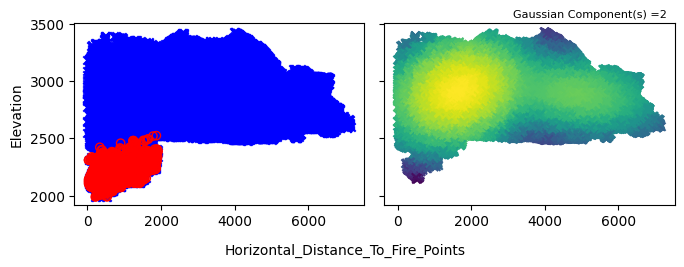

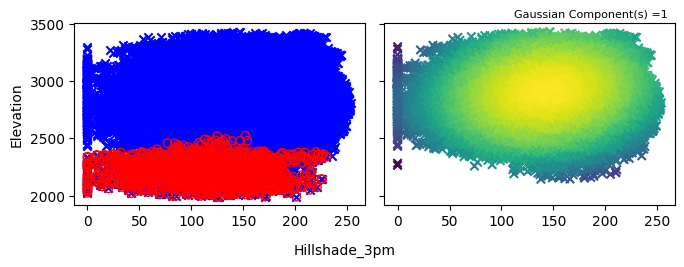

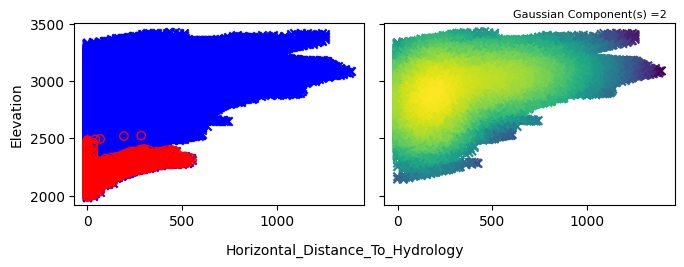

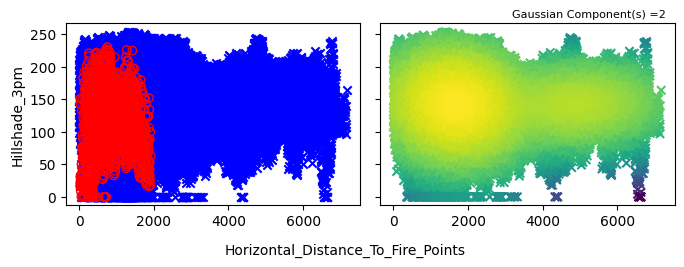

In [70]:
metric_table_twofeatures = pd.DataFrame(columns=('Feature1', 'Feature2', 'AUC_Train', 'AUC_Validation'))

metric_table_twofeatures = twoFeatureGaussianMix(feature1=9,
                                                 feature2=0,
                                                 n_components=2,
                                                 metric_table=metric_table_twofeatures)

metric_table_twofeatures = twoFeatureGaussianMix(feature1=8,
                                                 feature2=0,
                                                 n_components=1,
                                                 metric_table=metric_table_twofeatures)

metric_table_twofeatures = twoFeatureGaussianMix(feature1=3,
                                                 feature2=0,
                                                 n_components=2,
                                                 metric_table=metric_table_twofeatures)

metric_table_twofeatures = twoFeatureGaussianMix(feature1=9,
                                                 feature2=8,
                                                 n_components=2,
                                                 metric_table=metric_table_twofeatures)


**NOTE: The Gaussian Distribution plots on the right are fitted on non-anomalous forests. This fit is used only for plotting and observing the effect of `n_components` on the gaussian distribution.**

From the plots, Gaussian Distribution plots we can observe how the mixture models capture the dataset. For the `Hillshade_3pm` vs `Elevation` plot, a single component gaussian distribution suffices whereas for the rest of the pairs we require two gaussian components to improve the AUC score. 


In [75]:
print('AUC Scores for the selected feature pairs:')
metric_table_twofeatures

AUC Scores for the selected feature pairs:


,Feature1,Feature2,AUC_Train,AUC_Validation
0,Horizontal_Distance_To_Fire_Points,Elevation,0.994862,0.994990
1,Hillshade_3pm,Elevation,0.995740,0.995678
2,Horizontal_Distance_To_Hydrology,Elevation,0.993557,0.993735
3,Horizontal_Distance_To_Fire_Points,Hillshade_3pm,0.642272,0.637274


In [72]:
'''
Pick the set with the highest AUC on the validation set 
(out of the four sets that you tried)
'''
# Selecting inputs for AUC_Validation from the table above (2nd Row)
feature1 = 8
feature2 = 0
n_components = 2

gm_twofeature = GaussianMixture(n_components, random_state=0)
fit_data = np.array(X_train_inliers.iloc[:,[feature1, feature2]])
train_data = np.array(X_train.iloc[:,[feature1, feature2]])
val_data = np.array(X_val.iloc[:,[feature1, feature2]])
gm_twofeature.fit(train_data)

logProb_gm_train = gm_twofeature.score_samples(train_data)
logProb_gm_val = gm_twofeature.score_samples(val_data)

'''
Find a threshold to maximize your F1 Score on the validation set
'''
threshold = None
f1_score_max = None
interval_low = min(logProb_gm_val)
interval_high = max(logProb_gm_val)

while abs(interval_low - interval_high) > 0.05:
  mid1 = interval_low + (interval_high - interval_low)/3
  mid2 = interval_high - (interval_high - interval_low)/3
  y_pred_mid1 = np.zeros(len(y_val))
  y_pred_mid2 = np.zeros(len(y_val))

  y_pred_mid1[logProb_gm_val < mid1] = 1
  y_pred_mid2[logProb_gm_val < mid2] = 1
  f1_score_mid1 = f1_score(y_val, y_pred_mid1, average='binary') 
  f1_score_mid2 = f1_score(y_val, y_pred_mid2, average='binary') 

  if f1_score_mid1 <= f1_score_mid2:
    interval_low = mid1  
  else:
    interval_high = mid2
  
  threshold = mid2
  y_pred = y_pred_mid2
  f1_score_max = f1_score_mid2

y_predicted_train = np.zeros(len(y_train))
y_predicted_train[logProb_gm_train < threshold] = 1

y_predicted_val = np.zeros(len(y_val))
y_predicted_val[logProb_gm_val < threshold] = 1

f1_score_train = f1_score(y_train, y_predicted_train, average='binary')
f1_score_val = f1_score(y_val, y_predicted_val, average='binary')

f1_table_twofeatures_best = pd.DataFrame(columns=('Feature1', 'Feature2', 'Gaussian_Components', 'Threshold','F1_score_Train', 'F1_score_Val'))

row_data = {'Feature1':df.columns[feature1],
            'Feature2': df.columns[feature2],
            'Threshold': threshold,
            'Gaussian_Components': n_components,
            'F1_score_Train': f1_score_train,
            'F1_score_Val': f1_score_val}

f1_table_twofeatures_best = f1_table_twofeatures_best.append(row_data, ignore_index=True)
f1_table_twofeatures_best

,Feature1,Feature2,Gaussian_Components,Threshold,F1_score_Train,F1_score_Val
0,Hillshade_3pm,Elevation,2,-15.876104,0.63622,0.640545


Outliers based on optimal threshold: 


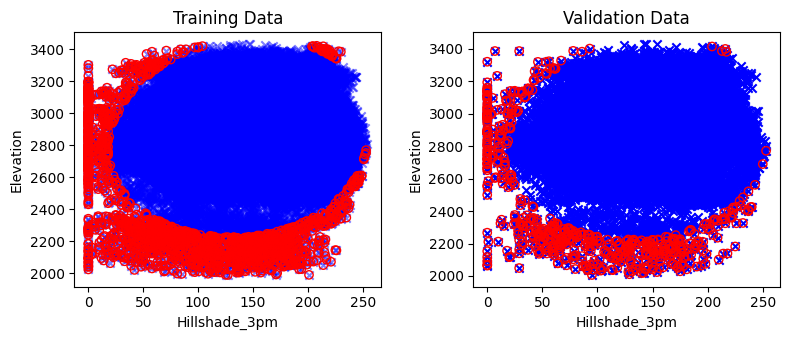

In [73]:
f1_train_data = X_train.iloc[:,feature1]
f2_train_data = X_train.iloc[:,feature2]

f1_val_data = X_val.iloc[:,feature1]
f2_val_data = X_val.iloc[:,feature2]

f1_train_outlier = X_train.iloc[:,feature1][y_predicted_train == 1]
f2_train_outlier = X_train.iloc[:,feature2][y_predicted_train == 1]

f1_val_outlier = X_val.iloc[:,feature1][y_predicted_val == 1]
f2_val_outlier = X_val.iloc[:,feature2][y_predicted_val == 1]

'''
Plot two seperate figures (one for the training data and one for the validation data) 
similar to step 3 and put a circle around outliers based on your threshold
 (use the code of the similar figure in tutorial)
'''
print('Outliers based on optimal threshold: ')
fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(8,3.5));
  
plt.subplot(1, 2, 1)
ax1.scatter(f1_train_data, f2_train_data,marker="x", color="blue", alpha=0.5);
# ax1.scatter(f1_train_data,f2_train_data,marker="x", c=logProb_gm_train, cmap='viridis');
ax1.scatter(f1_train_outlier,f2_train_outlier, marker="o", edgecolor="red", facecolor="none");
plt.xlabel(df.columns[feature1], size=10);
plt.ylabel(df.columns[feature2], size=10);
plt.title("Training Data", size=12)

plt.subplot(1, 2, 2)
ax2.scatter(f1_val_data, f2_val_data, marker="x", color="blue");
# ax2.scatter(f1_val_data,f2_val_data,marker="x", c=logProb_gm_val, cmap='viridis');
ax2.scatter(f1_val_outlier,f2_val_outlier, marker="o", edgecolor="red", facecolor="none");
plt.xlabel(df.columns[feature1], size=10);
plt.ylabel(df.columns[feature2], size=10);
plt.title("Validation Data", size=12)
# plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

fig1.tight_layout(w_pad=2)


## **Part 4:  Two Gaussian model with single feature.**
Now we will use two separate distributions for anomalous and non-anomalous forests.
  1.  Fit a Gaussian distribution ($G_1$) on a feature of **non-anomalous forests** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.5]**
  2. Fit another Gaussian distribution ($G_2$) on the same feature but for **anomalous forests** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.5]**
  3. Compute the score samples ($S$) for both $G_1$ and $G_2$ on the **validation set** to get $S_1$ and $S_2$, respectively. **[0.5]**
  4. Find an optimal $c$ (a real number) that maximizes validation set F1 Score for a model such that if $S_1 < c \times S_2$, the forest is classified as anomalous. For example, if $c=1$ we could say that if $S_2$ is greater than $S_1$, ($S_1$<$S_2$) then the forest is anomalous (the forest belongs to the $G_2$ distribution which represents anomalous forests). For start consider $c$ in $[0,10]$ with steps of 0.1, you can change this window in your experiments if needed. **[0.5]**
  5. Repeat the steps above for all the features. What is the best F1 Score, Precision and Recall that you get for training and validation? Which feature and what c? Show your results in a table. **[0.5]**
  6. Can we report AUC for this model? Why? **[0.5]**

In [20]:
n_components = 1


metric_table_2GSF = pd.DataFrame(columns=('Feature', 'Best_C', 'F1_score_Train', 'F1_score_Val', 
                                      'Precision_Train', 'Precision_Val', 
                                      'Recall_Train', 'Recall_Val'))

for features_ in range(len(X_train.columns)):
  '''
  Fit a Gaussian distribution ( G1 ) on a feature of non-anomalous forests 
  using sklearn.mixture.GaussianMixture when n_components=1
  '''
  gm_G1 = GaussianMixture(n_components, random_state=0)
  fit_data_G1 = np.array(X_train_inliers.iloc[:,features_]).reshape(-1,1)
  gm_G1.fit(fit_data_G1)

  '''
  Fit another Gaussian distribution ( G2 ) on the same feature but for 
  anomalous forests using sklearn.mixture.GaussianMixture when n_components=1.
  '''
  gm_G2 = GaussianMixture(n_components, random_state=0)
  fit_data_G2 = np.array(X_train_anomaly.iloc[:,features_]).reshape(-1,1)
  gm_G2.fit(fit_data_G2)

  val_data = np.array(X_val.iloc[:,features_]).reshape(-1,1)

  '''
  Compute the score samples ( S ) for both  G1  and  G2  on the
  validation set to get  S1  and  S2 , respectively.
  '''
  s1 = gm_G1.score_samples(val_data)
  s2 = gm_G2.score_samples(val_data)

  '''
  Find an optimal  c  (a real number) that maximizes validation set F1 Score for
  a model such that if  S1<c×S2 , the forest is classified as anomalous. 
  '''
  c_window = np.linspace(0,2,21)
  f1_score_max = 0
  c_best = None
  for c in c_window:
    y_predicted_val = np.zeros(len(y_val))
    y_predicted_val[s1 < c*s2] = 1
    f1_score_ = f1_score(y_val, y_predicted_val, average='binary')
    if f1_score_ > f1_score_max:
      f1_score_max = f1_score_
      c_best = c

  train_data = np.array(X_train.iloc[:,features_]).reshape(-1,1)
  s1_train = gm_G1.score_samples(train_data)
  s2_train = gm_G2.score_samples(train_data)
  y_predicted_train = np.zeros(len(y_train))
  y_predicted_train[s1_train < c_best*s2_train] = 1

  y_predicted_val = np.zeros(len(y_val))
  y_predicted_val[s1 < c_best*s2] = 1

  precision_train = precision_score(y_train, y_predicted_train)
  precision_val = precision_score(y_val, y_predicted_val)
  recall_train = recall_score(y_train, y_predicted_train)
  recall_val = recall_score(y_val, y_predicted_val)
  f1_train = f1_score(y_train, y_predicted_train, average='binary')
  f1_val = f1_score_max

  row_data = {'Feature':df.columns[features_],
              'Best_C':c_best,
              'F1_score_Train': f1_train,
              'F1_score_Val': f1_val,
              'Precision_Train': precision_train,
              'Precision_Val': precision_val,
              'Recall_Train': recall_train,
              'Recall_Val': recall_val}

  metric_table_2GSF = metric_table_2GSF.append(row_data, ignore_index=True)

metric_table_2GSF

,Feature,Best_C,F1_score_Train,F1_score_Val,Precision_Train,Precision_Val,Recall_Train,Recall_Val
0,Elevation,1.6,0.883733,0.875421,0.832175,0.818898,0.942102,0.940325
1,Aspect,1.0,0.022733,0.023574,0.011527,0.011954,0.816189,0.842676
2,Slope,1.4,0.069292,0.072386,0.045633,0.048071,0.143901,0.146474
3,Horizontal_Distance_To_Hydrology,1.1,0.042851,0.042778,0.022111,0.022082,0.690838,0.681736
4,Vertical_Distance_To_Hydrology,1.0,0.029388,0.028564,0.015045,0.014628,0.630129,0.603978
5,Horizontal_Distance_To_Roadways,1.1,0.051971,0.053082,0.026774,0.027350,0.882518,0.896926
6,Hillshade_9am,1.1,0.060529,0.060798,0.032414,0.032600,0.456436,0.450271
7,Hillshade_Noon,1.1,0.037131,0.036062,0.020201,0.019608,0.229342,0.224231
8,Hillshade_3pm,1.3,0.121783,0.118543,0.086894,0.084759,0.203485,0.197107
9,Horizontal_Distance_To_Fire_Points,1.2,0.049807,0.047094,0.026725,0.025279,0.365374,0.343580


In [21]:
print("Best Feature for two Gaussian Model: ")
best_2GSF = metric_table_2GSF.nlargest(1, ['F1_score_Val'])
best_2GSF

Best Feature for two Gaussian Model: 


,Feature,Best_C,F1_score_Train,F1_score_Val,Precision_Train,Precision_Val,Recall_Train,Recall_Val
0,Elevation,1.6,0.883733,0.875421,0.832175,0.818898,0.942102,0.940325


The AUC for the two gaussian model cannot be computed directly using the `sklearn.metrics.roc_auc_score`  as the target scores data (`y_score`) expects probability estimates of a data belonging to a class. This could require redifining the probability estimates based for the two different gaussian models. One way to obtain the AUC would be to numerically calulated by sweeping across a range of threshold values.  



## **Part 5: Multivariate and Mixture of Gaussians Distribution**
We now want to build an outlier detection model that performs well in terms of F1 score. To design your model, you can benefit from:

*   No restrictions on the number of features - use as few or as many as you want! (multivariate). 
*   To fit your model, you can take advantage of the Gaussian mixture model where you can set the number of components [help](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).
*   You can choose to fit your Gaussians on non-anomalous forests or to both classes. 


It is up to you how to design your model. Try at least 10 different models and report the AUC for both training and validation sets (if applicable) and the best F1 score, Precision and Recall (after tuning the threshold) for both training and validation sets for each model. What kind of model works better? How many features are best (and which ones)? How many Gaussians? How many components? Summarize your findings with tables or plots. **[3]**


**HINT !**

You might want to try a two gaussian model, multiple features, single component for valid forests and multiple components for anomalous ones! Why does it make sense to have multiple components for the anomalous forests?

In [23]:

# Two different Gaussian Models with single or multiple features
def multifeature_twoGaussian(features = [0], n_components_inlier = 1, n_components_outlier = 1, metric_table=None):
  gm_G1 = GaussianMixture(n_components_inlier, random_state=0)
  gm_G2 = GaussianMixture(n_components_outlier, random_state=0)
  if len(features) == 1:
    fit_data_G1 = np.array(X_train_inliers.iloc[:,features]).reshape(-1,1)
    fit_data_G2 = np.array(X_train_anomaly.iloc[:,features]).reshape(-1,1)
    train_data = np.array(X_train.iloc[:,features]).reshape(-1,1)
    val_data = np.array(X_val.iloc[:,features]).reshape(-1,1)
  else:
    fit_data_G1 = np.array(X_train_inliers.iloc[:,features])
    fit_data_G2 = np.array(X_train_anomaly.iloc[:,features])
    val_data = np.array(X_val.iloc[:,features])
    train_data = np.array(X_train.iloc[:,features])

  gm_G1.fit(fit_data_G1)
  gm_G2.fit(fit_data_G2)

  s1 = gm_G1.score_samples(val_data)
  s2 = gm_G2.score_samples(val_data)

  c_window = np.linspace(0,2,21)
  f1_score_max = 0
  c_best = None
  for c in c_window:
    y_predicted_val = np.zeros(len(y_val))
    y_predicted_val[s1 < c*s2] = 1
    f1_score_ = f1_score(y_val, y_predicted_val, average='binary')
    if f1_score_ > f1_score_max:
      f1_score_max = f1_score_
      c_best = c

  s1_train = gm_G1.score_samples(train_data)
  s2_train = gm_G2.score_samples(train_data)
  y_predicted_train = np.zeros(len(y_train))
  y_predicted_train[s1_train < c_best*s2_train] = 1

  y_predicted_val = np.zeros(len(y_val))
  y_predicted_val[s1 < c_best*s2] = 1

  precision_train = precision_score(y_train, y_predicted_train)
  precision_val = precision_score(y_val, y_predicted_val)
  recall_train = recall_score(y_train, y_predicted_train)
  recall_val = recall_score(y_val, y_predicted_val)
  f1_train = f1_score(y_train, y_predicted_train, average='binary')
  f1_val = f1_score_max

  remark = "Two Gaussian n_comp: " + \
           "("+ str(n_components_inlier) + \
            "," + str(n_components_outlier)+")"

  row_data = {'Feature_ID(s)':features,
              'Best_Threshold':[None],
              'Best_C':c_best,
              'AUC_Train':[None],
              'AUC_Val':[None],
              'F1_score_Train': f1_train,
              'F1_score_Val': f1_val,
              'Precision_Train': precision_train,
              'Precision_Val': precision_val,
              'Recall_Train': recall_train,
              'Recall_Val': recall_val,
              'Remark': remark}

  metric_table = metric_table.append(row_data, ignore_index=True)
  return metric_table


# Single Gaussian Model with single or multiple features
def multiFeature_singleGaussian(features, n_components, metric_table):

  if len(features) == 1:
    fit_data = np.array(X_train_inliers.iloc[:,features]).reshape(-1,1)
    train_data = np.array(X_train.iloc[:,features]).reshape(-1,1)
    val_data = np.array(X_val.iloc[:,features]).reshape(-1,1)
  else:
    fit_data = np.array(X_train_inliers.iloc[:,features])
    val_data = np.array(X_val.iloc[:,features])
    train_data = np.array(X_train.iloc[:,features])

  gm_nfeature = GaussianMixture(n_components, random_state=0)
  gm_nfeature.fit(train_data)
  logProb_gm_train = gm_nfeature.score_samples(train_data)
  auc_train = roc_auc_score(y_train, -1 * logProb_gm_train)
  logProb_gm_val = gm_nfeature.score_samples(val_data)
  auc_val = roc_auc_score(y_val, -1 * logProb_gm_val)

  threshold = None
  f1_score_max = None
  interval_low = min(logProb_gm_val)
  interval_high = max(logProb_gm_val)

  while abs(interval_low - interval_high) > 0.05:
    mid1 = interval_low + (interval_high - interval_low)/3
    mid2 = interval_high - (interval_high - interval_low)/3
    y_pred_mid1 = np.zeros(len(y_val))
    y_pred_mid2 = np.zeros(len(y_val))

    y_pred_mid1[logProb_gm_val < mid1] = 1
    y_pred_mid2[logProb_gm_val < mid2] = 1
    f1_score_mid1 = f1_score(y_val, y_pred_mid1, average='binary') 
    f1_score_mid2 = f1_score(y_val, y_pred_mid2, average='binary') 

    if f1_score_mid1 <= f1_score_mid2:
      interval_low = mid1  
    else:
      interval_high = mid2
    
    threshold = mid2
    f1_score_max = f1_score_mid2

  y_predicted_train = np.zeros(len(y_train))
  y_predicted_train[logProb_gm_train < threshold] = 1
  
  precision_train = precision_score(y_train, y_predicted_train)
  precision_val = precision_score(y_val, y_predicted_val)
  recall_train = recall_score(y_train, y_predicted_train)
  recall_val = recall_score(y_val, y_predicted_val)
  f1_train = f1_score(y_train, y_predicted_train, average='binary')
  f1_val = f1_score_max

  remark = "One Gaussian with " + str(len(features)) + " features" 
  row_data = {'Feature_ID(s)':features,
              'Best_Threshold': threshold,
              'Best_C':[None],
              'AUC_Train': auc_train,
              'AUC_Val': auc_val,
              'F1_score_Train': f1_train,
              'F1_score_Val': f1_val,
              'Precision_Train': precision_train,
              'Precision_Val': precision_val,
              'Recall_Train': recall_train,
              'Recall_Val': recall_val,
              'Remark': remark}
  metric_table = metric_table.append(row_data, ignore_index=True)
  return metric_table



In the code below, we consider 4 best features based on the F1_scores in Part1 through Part4. For the first part, we use Two Gaussians and generate 48 different calssifier models varying the number of features and both the gaussian components. For the second part, we use the single gaussian mixture model and  generate 16 classifier models varying the number of features and the Gaussian components. The results of all the 64 classifier models are stored in a dataframe. 

In [25]:
metric_table = pd.DataFrame(columns=('Feature_ID(s)', 'Best_Threshold', 'Best_C',
                                     'AUC_Train', 'AUC_Val', 'F1_score_Train', 
                                     'F1_score_Val', 'Precision_Train', 
                                     'Precision_Val', 'Recall_Train', 'Recall_Val',
                                     'Remark'))
best5_features = [0,9,8,3]

for f in range(2,len(best5_features)+1):
  for i  in range(1,5):
    for j in range (1,5):
      metric_table = multifeature_twoGaussian(features=best5_features[0:f], n_components_inlier=i, n_components_outlier=j, metric_table=metric_table)

for f in range(1,len(best5_features)+1):
  for i  in range(1,5):
    metric_table = multiFeature_singleGaussian(features=best5_features[0:f], n_components=i, metric_table=metric_table)


In [76]:
print("Perfromance for all Classifier Models: ")
metric_table

Perfromance for all Classifier Models: 


,Feature_ID(s),Best_Threshold,Best_C,AUC_Train,AUC_Val,F1_score_Train,F1_score_Val,Precision_Train,Precision_Val,Recall_Train,Recall_Val,Remark
0,"[0, 9]",[None],1.3,[None],[None],0.871241,0.864865,0.802557,0.790419,0.952782,0.954792,"Two Gaussian n_comp: (1,1)"
1,"[0, 9]",[None],1.3,[None],[None],0.875223,0.870915,0.801402,0.794337,0.964025,0.963834,"Two Gaussian n_comp: (1,2)"
2,"[0, 9]",[None],1.3,[None],[None],0.879346,0.875817,0.806376,0.798808,0.966835,0.969259,"Two Gaussian n_comp: (1,3)"
3,"[0, 9]",[None],1.3,[None],[None],0.881946,0.880000,0.809972,0.802083,0.967960,0.974684,"Two Gaussian n_comp: (1,4)"
4,"[0, 9]",[None],1.3,[None],[None],0.872133,0.866723,0.821251,0.807813,0.929736,0.934901,"Two Gaussian n_comp: (2,1)"
...,...,...,...,...,...,...,...,...,...,...,...,...
59,"[0, 9, 8]",-24.040497,[None],0.980819,0.981043,0.424338,0.435303,0.355034,0.025279,0.527263,0.343580,One Gaussian with 3 features
60,"[0, 9, 8, 3]",-32.272513,[None],0.983034,0.982876,0.420330,0.422481,0.322882,0.025279,0.602024,0.343580,One Gaussian with 4 features
61,"[0, 9, 8, 3]",-31.193345,[None],0.978927,0.979297,0.366390,0.376827,0.257909,0.025279,0.632378,0.343580,One Gaussian with 4 features
62,"[0, 9, 8, 3]",-30.371999,[None],0.971404,0.971933,0.293852,0.300914,0.189146,0.025279,0.658235,0.343580,One Gaussian with 4 features


In [28]:
best_models = metric_table.nlargest(15, ['F1_score_Val'])
best_models

,Feature_ID(s),Best_Threshold,Best_C,AUC_Train,AUC_Val,F1_score_Train,F1_score_Val,Precision_Train,Precision_Val,Recall_Train,Recall_Val,Remark
43,"[0, 9, 8, 3]",[None],1.2,[None],[None],0.934752,0.940966,0.931362,0.930973,0.938168,0.951175,"Two Gaussian n_comp: (3,4)"
39,"[0, 9, 8, 3]",[None],1.2,[None],[None],0.933665,0.933333,0.918434,0.906303,0.949410,0.962025,"Two Gaussian n_comp: (2,4)"
47,"[0, 9, 8, 3]",[None],1.2,[None],[None],0.931984,0.932021,0.931984,0.922124,0.931984,0.942134,"Two Gaussian n_comp: (4,4)"
35,"[0, 9, 8, 3]",[None],1.2,[None],[None],0.930308,0.927461,0.895476,0.887603,0.967960,0.971067,"Two Gaussian n_comp: (1,4)"
41,"[0, 9, 8, 3]",[None],1.2,[None],[None],0.924402,0.922252,0.914239,0.911661,0.934795,0.933092,"Two Gaussian n_comp: (3,2)"
42,"[0, 9, 8, 3]",[None],1.2,[None],[None],0.923077,0.920213,0.912184,0.902609,0.934233,0.938517,"Two Gaussian n_comp: (3,3)"
45,"[0, 9, 8, 3]",[None],1.2,[None],[None],0.909347,0.908766,0.910886,0.899115,0.907813,0.918626,"Two Gaussian n_comp: (4,2)"
37,"[0, 9, 8, 3]",[None],1.2,[None],[None],0.912262,0.905135,0.885246,0.872483,0.940978,0.940325,"Two Gaussian n_comp: (2,2)"
34,"[0, 9, 8, 3]",[None],1.2,[None],[None],0.902716,0.901598,0.850050,0.842767,0.962338,0.969259,"Two Gaussian n_comp: (1,3)"
46,"[0, 9, 8, 3]",[None],1.2,[None],[None],0.909192,0.901235,0.898463,0.879518,0.920180,0.924051,"Two Gaussian n_comp: (4,3)"


The best 15 models are listed in the dataframe above. It is observed that the all these models use the two-gaussian multi-feature variant. The results show that 4 features i.e. `Elevation`, `Hillshade_3pm`, `Horizontal_Distance_To_Hydrology`, `Horizontal_Distance_To_Fire_Points` provide the best F1_score in both the training and the validation set. The top 4 classifier models all use 4 gaussian components for the anomalous forests which suggest the spread in clustering of the anomalous samples in the four dimensional feature space. 

The best anomaly detection model gives the validation **F1_score of 0.941**. The threshold $c$ (for two-gaussian models) is 1.2, non-anomalous gaussian components are 3 and anomalous gaussian components are 4. 

## **Part 6: Evaluating performance on test set: [1 Mark]**
**Which model worked better?** Pick your best model among all models and apply it to your test set. Report the F1 Score, Precision and Recall on the test set. **[1]**


In [52]:
test_data_perf = pd.DataFrame(columns=('Features', 'Feature_Count','Best_C',
                                     'F1_score_Train','F1_score_Val', 
                                     'F1_score_Test', 'Precision_Train', 
                                     'Precision_Val', 'Precision_Test',
                                     'Recall_Train', 'Recall_Val', 'Recall_Test'))
features = [0, 9, 8, 3]
n_components_inlier = 3
n_components_outlier = 4
c_best = 1.2

gm_G1 = GaussianMixture(n_components_inlier, random_state=0)
gm_G2 = GaussianMixture(n_components_outlier, random_state=0)
  
fit_data_G1 = np.array(X_train_inliers.iloc[:,features])
fit_data_G2 = np.array(X_train_anomaly.iloc[:,features])
train_data = np.array(X_train.iloc[:,features])
val_data = np.array(X_val.iloc[:,features])
test_data = np.array(X_test.iloc[:,features])

gm_G1.fit(fit_data_G1)
gm_G2.fit(fit_data_G2)

s1_val = gm_G1.score_samples(val_data)
s2_val = gm_G2.score_samples(val_data)

s1_train = gm_G1.score_samples(train_data)
s2_train = gm_G2.score_samples(train_data)

s1_test = gm_G1.score_samples(test_data)
s2_test = gm_G2.score_samples(test_data)

y_predicted_train = np.zeros(len(y_train))
y_predicted_train[s1_train < c_best*s2_train] = 1

y_predicted_val = np.zeros(len(y_val))
y_predicted_val[s1_val < c_best*s2_val] = 1

y_predicted_test = np.zeros(len(y_test))
y_predicted_test[s1_test < c_best*s2_test] = 1

precision_train = precision_score(y_train, y_predicted_train)
precision_val = precision_score(y_val, y_predicted_val)
precision_test = precision_score(y_test, y_predicted_test)
recall_train = recall_score(y_train, y_predicted_train)
recall_val = recall_score(y_val, y_predicted_val)
recall_test = recall_score(y_test, y_predicted_test)
f1_train = f1_score(y_train, y_predicted_train, average='binary')
f1_val = f1_score(y_val, y_predicted_val, average='binary')
f1_test = f1_score(y_test, y_predicted_test, average='binary')


row_data = {'Features':df.columns[features].values,
            'Feature_Count': len(features),
            'Best_C':c_best,
            'F1_score_Train': f1_train,
            'F1_score_Val': f1_val,
            'F1_score_Test': f1_test,
            'Precision_Train': precision_train,
            'Precision_Val': precision_val,
            'Precision_Test': precision_test,
            'Recall_Train': recall_train,
            'Recall_Val': recall_val,
            'Recall_Test': recall_test}

test_data_perf = test_data_perf.append(row_data, ignore_index=True)

The results of the anomaly detection model are as summarized in the dataframe below. **The F1_score for the model on the test set is 0.930**. 

In [53]:
test_data_perf

,Features,Feature_Count,Best_C,F1_score_Train,F1_score_Val,F1_score_Test,Precision_Train,Precision_Val,Precision_Test,Recall_Train,Recall_Val,Recall_Test
0,"[Elevation, Horizontal_Distance_To_Fire_Points...",4,1.2,0.934752,0.940966,0.929952,0.931362,0.930973,0.932203,0.938168,0.951175,0.927711


## **Bonus Part: Using the Precision Recall Curve:**
Repeat Part 2 using the Precision Recall Curve instead of the ROC curve.

In [32]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

prc_table_oneFeature = pd.DataFrame(columns=('Feature', 'PR-AUC_Train', "PR-AUC_Validation"))
gm = GaussianMixture(n_components=1, random_state=0)
for features_ in range(len(X_train.columns)):
  train_data = np.array(X_train.iloc[:,features_]).reshape(-1,1)
  val_data = np.array(X_val.iloc[:,features_]).reshape(-1,1)
  gm.fit(train_data)
  logProb_gm_train = gm.score_samples(train_data)
  precision_train, recall_train, _ = precision_recall_curve(y_train, -1*logProb_gm_train)
  pr_auc_train = auc(recall_train, precision_train)
 
  logProb_gm_val = gm.score_samples(val_data)
  precision_val, recall_val, _ = precision_recall_curve(y_val, -1*logProb_gm_val)
  pr_auc_val = auc(recall_val, precision_val)
  
  prc_table_oneFeature.loc[features_] = [df.columns[features_], pr_auc_train, pr_auc_val]

prc_table_oneFeature

,Feature,PR-AUC_Train,PR-AUC_Validation
0,Elevation,0.929339,0.915046
1,Aspect,0.007220,0.007067
2,Slope,0.023037,0.023827
3,Horizontal_Distance_To_Hydrology,0.015522,0.015313
4,Vertical_Distance_To_Hydrology,0.013419,0.013193
5,Horizontal_Distance_To_Roadways,0.010966,0.011268
6,Hillshade_9am,0.015985,0.015698
7,Hillshade_Noon,0.013387,0.012942
8,Hillshade_3pm,0.041241,0.037016
9,Horizontal_Distance_To_Fire_Points,0.013977,0.013632


In [33]:
print("Best 3 features to classify anomalous forests (PR-AUC): ")
best_prc_df = prc_table_oneFeature.nlargest(3, ['PR-AUC_Validation'])
best_prc_df

Best 3 features to classify anomalous forests (PR-AUC): 


,Feature,PR-AUC_Train,PR-AUC_Validation
0,Elevation,0.929339,0.915046
8,Hillshade_3pm,0.041241,0.037016
2,Slope,0.023037,0.023827


In [35]:
prc_OGSF_df = pd.DataFrame(columns=('Feature', 'Threshold', "F1_score_Val"))

threshold_values = np.zeros(best_prc_df.shape[0])
f1_scores = np.zeros(best_prc_df.shape[0])


for i in range(best_prc_df.shape[0]):
  train_data = np.array(X_train[best_prc_df.iloc[i]['Feature']]).reshape(-1,1)
  val_data = np.array(X_val[best_prc_df.iloc[i]['Feature']]).reshape(-1,1)
  gm.fit(train_data)
  logProb_gm_val = gm.score_samples(val_data)
  threshold = None
  f1_score_max = None
  interval_low = min(logProb_gm_val)
  interval_high = max(logProb_gm_val)
  # print(abs(interval_low - interval_high), best_auc_df.iloc[i]['Feature'] )
  while abs(interval_low - interval_high) > 0.1:
    mid1 = interval_low + (interval_high - interval_low)/3
    mid2 = interval_high - (interval_high - interval_low)/3
    y_pred_mid1 = np.zeros(len(y_val))
    y_pred_mid2 = np.zeros(len(y_val))

    y_pred_mid1[logProb_gm_val < mid1] = 1
    y_pred_mid2[logProb_gm_val < mid2] = 1
    f1_score_mid1 = f1_score(y_val, y_pred_mid1, average='binary') 
    f1_score_mid2 = f1_score(y_val, y_pred_mid2, average='binary') 

    if f1_score_mid1 <= f1_score_mid2:
      interval_low = mid1  
    else:
      interval_high = mid2
    
    threshold = mid2
    f1_score_max = f1_score_mid2

  prc_OGSF_df.loc[i] = [best_prc_df.iloc[i]['Feature'],
                           round(threshold,1),
                           round(f1_score_max,4)]

  threshold_values[i] = threshold
  f1_scores[i] = f1_score_max

print("Optimized Threshold for Best 3 features (based on GaussianMixture.score_samples) ")
prc_OGSF_df

Optimized Threshold for Best 3 features (based on GaussianMixture.score_samples) 


,Feature,Threshold,F1_score_Val
0,Elevation,-9.9,0.8787
1,Hillshade_3pm,-7.7,0.0952
2,Slope,-4.7,0.0780


In [36]:
precision_scores_train = []
precision_scores_val = []
recall_scores_train = []
recall_scores_val = []
f1_scores_train = []

for i in range(prc_OGSF_df.shape[0]):
  train_data = np.array(X_train[prc_OGSF_df.iloc[i]['Feature']]).reshape(-1,1)
  val_data = np.array(X_val[prc_OGSF_df.iloc[i]['Feature']]).reshape(-1,1)
  y_predicted_train = np.zeros(len(y_train))
  y_predicted_val = np.zeros(len(y_val))

  gm.fit(train_data)
  logProb_gm_train = gm.score_samples(train_data)
  logProb_gm_val = gm.score_samples(val_data)

  threshold = OGSF_df.iloc[i]['Threshold']
  
  y_predicted_train[logProb_gm_train < threshold] = 1
  y_predicted_val[logProb_gm_val < threshold] = 1

  precision_scores_train.append(precision_score(y_train, y_predicted_train))
  precision_scores_val.append(precision_score(y_val, y_predicted_val))

  recall_scores_train.append(recall_score(y_train, y_predicted_train))
  recall_scores_val.append(recall_score(y_val, y_predicted_val))

  f1_scores_train.append(f1_score(y_train, y_predicted_train, average='binary'))

prc_OGSF_df['F1_score_Train'] = precision_scores_train
prc_OGSF_df['Precision_Train'] = precision_scores_train
prc_OGSF_df['Precision_Val'] = precision_scores_val
prc_OGSF_df['Recall_Train'] = recall_scores_train
prc_OGSF_df['Recall_Val'] = recall_scores_val

prc_OGSF_df

,Feature,Threshold,F1_score_Val,F1_score_Train,Precision_Train,Precision_Val,Recall_Train,Recall_Val
0,Elevation,-9.9,0.8787,0.826341,0.826341,0.815100,0.952220,0.956600
1,Hillshade_3pm,-7.7,0.0952,0.111111,0.111111,0.097187,0.080382,0.068716
2,Slope,-4.7,0.0780,0.050209,0.050209,0.044444,0.033727,0.028933


In [54]:
prc_OGSF_oneclass_df = pd.DataFrame(columns=('Feature', 'Threshold', "F1_score_Val"))

threshold_values = np.zeros(best_prc_df.shape[0])
f1_scores = np.zeros(best_prc_df.shape[0])

X_train_oneclass = X_train[y_train == 0]

for i in range(best_auc_df.shape[0]):
  fit_data = np.array(X_train_oneclass[best_prc_df.iloc[i]['Feature']]).reshape(-1,1)
  val_data = np.array(X_val[best_prc_df.iloc[i]['Feature']]).reshape(-1,1)
  gm.fit(fit_data)
  logProb_gm_val = gm.score_samples(val_data)
  threshold = None
  f1_score_max = None
  interval_low = min(logProb_gm_val)
  interval_high = max(logProb_gm_val)

  while abs(interval_low - interval_high) > 0.1:
    mid1 = interval_low + (interval_high - interval_low)/3
    mid2 = interval_high - (interval_high - interval_low)/3
    y_pred_mid1 = np.zeros(len(y_val))
    y_pred_mid2 = np.zeros(len(y_val))

    y_pred_mid1[logProb_gm_val < mid1] = 1
    y_pred_mid2[logProb_gm_val < mid2] = 1
    f1_score_mid1 = f1_score(y_val, y_pred_mid1, average='binary') 
    f1_score_mid2 = f1_score(y_val, y_pred_mid2, average='binary') 

    if f1_score_mid1 <= f1_score_mid2:
      interval_low = mid1  
    else:
      interval_high = mid2
    
    threshold = mid2
    f1_score_max = f1_score_mid2

  prc_OGSF_oneclass_df.loc[i] = [best_prc_df.iloc[i]['Feature'],
                           round(threshold,1),
                           round(f1_score_max,4)]

  threshold_values[i] = threshold
  f1_scores[i] = f1_score_max

print("Optimized Threshold for Best 3 features based on PR_AUC (Model Fit only on Non-Anomalous Data) ")

precision_scores_train = []
precision_scores_val = []
recall_scores_train = []
recall_scores_val = []
f1_scores_train = []

for i in range(prc_OGSF_oneclass_df.shape[0]):
  fit_data = np.array(X_train_oneclass[prc_OGSF_oneclass_df.iloc[i]['Feature']]).reshape(-1,1)
  train_data = np.array(X_train[prc_OGSF_oneclass_df.iloc[i]['Feature']]).reshape(-1,1)
  val_data = np.array(X_val[prc_OGSF_oneclass_df.iloc[i]['Feature']]).reshape(-1,1)
  y_predicted_train = np.zeros(len(y_train))
  y_predicted_val = np.zeros(len(y_val))

  gm.fit(fit_data)
  logProb_gm_train = gm.score_samples(train_data)
  logProb_gm_val = gm.score_samples(val_data)

  threshold = prc_OGSF_oneclass_df.iloc[i]['Threshold']
  
  y_predicted_train[logProb_gm_train < threshold] = 1
  y_predicted_val[logProb_gm_val < threshold] = 1

  precision_scores_train.append(precision_score(y_train, y_predicted_train))
  precision_scores_val.append(precision_score(y_val, y_predicted_val))

  recall_scores_train.append(recall_score(y_train, y_predicted_train))
  recall_scores_val.append(recall_score(y_val, y_predicted_val))

  f1_scores_train.append(f1_score(y_train, y_predicted_train, average='binary'))

prc_OGSF_oneclass_df['F1_score_Train'] = precision_scores_train
prc_OGSF_oneclass_df['Precision_Train'] = precision_scores_train
prc_OGSF_oneclass_df['Precision_Val'] = precision_scores_val
prc_OGSF_oneclass_df['Recall_Train'] = recall_scores_train
prc_OGSF_oneclass_df['Recall_Val'] = recall_scores_val

prc_OGSF_oneclass_df


Optimized Threshold for Best 3 features from PR_AUC (Model Fit only on Non-Anomalous Data) 


,Feature,Threshold,F1_score_Val,F1_score_Train,Precision_Train,Precision_Val,Recall_Train,Recall_Val
0,Elevation,-10.1,0.8792,0.803803,0.803803,0.797059,0.974143,0.980108
1,Hillshade_3pm,-7.8,0.0952,0.078281,0.078281,0.081737,0.114671,0.115732
2,Slope,-4.7,0.0780,0.040556,0.040556,0.046350,0.196740,0.216998
